In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
INPUT_FOLDER = 'geolife-trajectories/processed_data/'
FILE_NAME = INPUT_FOLDER + 'BeijingWalkingAreas.csv'

if not os.path.exists(FILE_NAME):
    list_df = []
    for file in os.listdir(INPUT_FOLDER):
        df = pd.read_csv(INPUT_FOLDER + file)
        list_df.append(df)
    df = pd.concat(list_df, ignore_index=True)
    df.drop('Unnamed: 0', inplace=True, axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='ignore')
    # Beijing
    latMinB = 39.64
    latMaxB = 40.51
    longMinB = 115.76
    longMaxB = 116.88
    df = df[(df.lat.between(latMinB, latMaxB)) & (df.long.between(longMinB, longMaxB))]
    df = df[df['labels'] == 'walk']
    df = df[['lat', 'long', 'datetime', 'trajectory_id']]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(FILE_NAME, index=False)

df = pd.read_csv(FILE_NAME)
if 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])

# drop short trajectories
traj_len = 10
long_traj = df['trajectory_id'].value_counts()
long_traj = long_traj.where(long_traj.values > traj_len).dropna().keys()
df = df.loc[df['trajectory_id'].isin(long_traj)]
df.head()

,lat,long,datetime,trajectory_id
0,39.900008,116.412534,2008-06-17 10:53:07,20080617094444
1,39.900011,116.412560,2008-06-17 10:53:08,20080617094444
2,39.900015,116.412581,2008-06-17 10:53:09,20080617094444
3,39.900021,116.412616,2008-06-17 10:53:11,20080617094444
4,39.900030,116.412639,2008-06-17 10:53:12,20080617094444


2009-08-07 15:49:03 2008-11-05 11:33:07 2007-04-14 00:56:28 2011-12-31 15:18:07


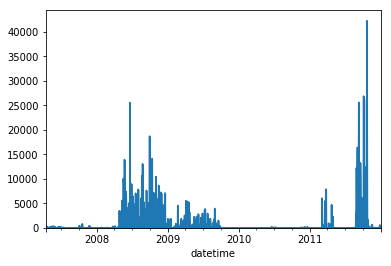

In [3]:
# get some datetime statistics: avg, med, min, max
def func_datetime(series, func=np.average):
    dt_min = series.min()
    deltas = [(x-dt_min).total_seconds() for x in series]
    return dt_min + np.timedelta64(int(func(deltas)), 's')

print(func_datetime(df['datetime']), func_datetime(df['datetime'], func=np.median), df['datetime'].min(), df['datetime'].max())
df.set_index('datetime').resample('D').count().lat.plot(kind='area')

In [4]:
# compress data to have unit time intervals
# for now I've decided to use one minute interval
def compress(df, verbose=False):
    list_df = []
    iter_count = 0
    if verbose:
        print('Amount of iterations needed: ' + str(len(df['trajectory_id'].unique())))
    for t_id in df['trajectory_id'].unique():
        iter_count += 1
        single_trajectory = df.loc[df['trajectory_id']==t_id]
        single_trajectory['datetime'] = pd.to_datetime(single_trajectory['datetime'].values.astype('<M8[m]'))
        list_single_df = []
        for st_dt in single_trajectory['datetime'].unique():
            avg_values = single_trajectory[['lat', 'long']].loc[single_trajectory['datetime'].values==st_dt].mean().values.tolist() + [st_dt, t_id]
            list_single_df.append(pd.DataFrame(np.reshape(avg_values, (1, len(avg_values))), columns=df.columns.values))
        list_df.append(pd.concat(list_single_df, ignore_index=True))
        if verbose:
            print('Iteration ' + str(iter_count) + ': Added ' + str(list_df[-1].count()[0]) + ' rows\n')
    return pd.concat(list_df, ignore_index=True)

df_compressed = compress(df)
df_compressed['datetime'] = pd.DatetimeIndex(df_compressed['datetime'].values)
df_compressed.head()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,lat,long,datetime,trajectory_id
0,39.9001,116.413,2008-06-17 10:53:00,20080617094444
1,39.9001,116.414,2008-06-17 10:54:00,20080617094444
2,39.9001,116.415,2008-06-17 10:55:00,20080617094444
3,39.9002,116.417,2008-06-17 10:56:00,20080617094444
4,39.9004,116.418,2008-06-17 10:57:00,20080617094444


In [5]:
# the database isn't ideal for snapshot creating
len(df_compressed['datetime'].unique()) / len(df_compressed)

0.9123468426013195

In [6]:
# let's treat datetime column as only the time, i.e. as if all trajectories are recorded in the same day
df_compressed['datetime'] = pd.Series([val.time() for val in df_compressed['datetime']])
df_compressed.head()

,lat,long,datetime,trajectory_id
0,39.9001,116.413,10:53:00,20080617094444
1,39.9001,116.414,10:54:00,20080617094444
2,39.9001,116.415,10:55:00,20080617094444
3,39.9002,116.417,10:56:00,20080617094444
4,39.9004,116.418,10:57:00,20080617094444


In [7]:
# perform clusterization, look at the number of clusters
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.001, min_samples=2)
for s_dt in df_compressed['datetime'].unique():
    db.fit(df_compressed[['lat', 'long']].loc[df_compressed['datetime']==s_dt])
    n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    print('Time: ' + str(s_dt) + '\nEstimated number of clusters: %d\n' % n_clusters_)

Time: 10:53:00
Estimated number of clusters: 6

Time: 10:54:00
Estimated number of clusters: 9

Time: 10:55:00
Estimated number of clusters: 8

Time: 10:56:00
Estimated number of clusters: 9

Time: 10:57:00
Estimated number of clusters: 9

Time: 10:58:00
Estimated number of clusters: 7

Time: 10:59:00
Estimated number of clusters: 5

Time: 11:00:00
Estimated number of clusters: 6

Time: 03:44:00
Estimated number of clusters: 4

Time: 03:45:00
Estimated number of clusters: 3

Time: 03:46:00
Estimated number of clusters: 3

Time: 03:47:00
Estimated number of clusters: 3

Time: 03:48:00
Estimated number of clusters: 1

Time: 03:49:00
Estimated number of clusters: 2

Time: 03:50:00
Estimated number of clusters: 3

Time: 03:51:00
Estimated number of clusters: 2

Time: 03:52:00
Estimated number of clusters: 1

Time: 12:10:00
Estimated number of clusters: 12

Time: 12:11:00
Estimated number of clusters: 10

Time: 12:12:00
Estimated number of clusters: 9

Time: 12:13:00
Estimated number of clu

Time: 01:14:00
Estimated number of clusters: 5

Time: 11:28:00
Estimated number of clusters: 13

Time: 11:29:00
Estimated number of clusters: 15

Time: 11:30:00
Estimated number of clusters: 16

Time: 11:31:00
Estimated number of clusters: 11

Time: 00:39:00
Estimated number of clusters: 9

Time: 00:40:00
Estimated number of clusters: 10

Time: 00:41:00
Estimated number of clusters: 11

Time: 00:42:00
Estimated number of clusters: 7

Time: 00:43:00
Estimated number of clusters: 8

Time: 12:09:00
Estimated number of clusters: 11

Time: 11:14:00
Estimated number of clusters: 12

Time: 11:18:00
Estimated number of clusters: 12

Time: 11:19:00
Estimated number of clusters: 15

Time: 14:41:00
Estimated number of clusters: 5

Time: 14:42:00
Estimated number of clusters: 5

Time: 14:43:00
Estimated number of clusters: 6

Time: 00:25:00
Estimated number of clusters: 7

Time: 00:26:00
Estimated number of clusters: 5

Time: 00:27:00
Estimated number of clusters: 6

Time: 05:18:00
Estimated numbe

Time: 15:30:00
Estimated number of clusters: 3

Time: 15:32:00
Estimated number of clusters: 5

Time: 15:33:00
Estimated number of clusters: 6

Time: 15:34:00
Estimated number of clusters: 5

Time: 15:35:00
Estimated number of clusters: 3

Time: 15:36:00
Estimated number of clusters: 3

Time: 15:37:00
Estimated number of clusters: 3

Time: 15:38:00
Estimated number of clusters: 3

Time: 15:39:00
Estimated number of clusters: 3

Time: 15:40:00
Estimated number of clusters: 5

Time: 15:41:00
Estimated number of clusters: 4

Time: 15:42:00
Estimated number of clusters: 2

Time: 15:43:00
Estimated number of clusters: 3

Time: 15:44:00
Estimated number of clusters: 2

Time: 15:45:00
Estimated number of clusters: 2

Time: 15:46:00
Estimated number of clusters: 2

Time: 15:48:00
Estimated number of clusters: 1

Time: 15:51:00
Estimated number of clusters: 1

Time: 15:52:00
Estimated number of clusters: 2

Time: 15:53:00
Estimated number of clusters: 1

Time: 15:54:00
Estimated number of clust

Time: 00:51:00
Estimated number of clusters: 7

Time: 01:21:00
Estimated number of clusters: 4

Time: 01:22:00
Estimated number of clusters: 7

Time: 02:22:00
Estimated number of clusters: 3

Time: 02:25:00
Estimated number of clusters: 4

Time: 02:26:00
Estimated number of clusters: 3

Time: 02:27:00
Estimated number of clusters: 5

Time: 02:28:00
Estimated number of clusters: 5

Time: 02:30:00
Estimated number of clusters: 5

Time: 02:31:00
Estimated number of clusters: 6

Time: 02:46:00
Estimated number of clusters: 4

Time: 02:47:00
Estimated number of clusters: 5

Time: 02:48:00
Estimated number of clusters: 5

Time: 02:49:00
Estimated number of clusters: 4

Time: 02:50:00
Estimated number of clusters: 3

Time: 02:51:00
Estimated number of clusters: 4

Time: 02:52:00
Estimated number of clusters: 5

Time: 02:53:00
Estimated number of clusters: 5

Time: 04:14:00
Estimated number of clusters: 7

Time: 04:19:00
Estimated number of clusters: 6

Time: 04:20:00
Estimated number of clust

Time: 12:35:00
Estimated number of clusters: 4

Time: 12:36:00
Estimated number of clusters: 4

Time: 12:37:00
Estimated number of clusters: 8

Time: 12:26:00
Estimated number of clusters: 9

Time: 12:27:00
Estimated number of clusters: 9

Time: 12:28:00
Estimated number of clusters: 8

Time: 12:29:00
Estimated number of clusters: 9

Time: 12:30:00
Estimated number of clusters: 5

Time: 12:31:00
Estimated number of clusters: 4

Time: 12:32:00
Estimated number of clusters: 5

Time: 12:33:00
Estimated number of clusters: 10

Time: 12:34:00
Estimated number of clusters: 5

Time: 12:40:00
Estimated number of clusters: 9

Time: 12:41:00
Estimated number of clusters: 9

Time: 12:50:00
Estimated number of clusters: 8

Time: 13:06:00
Estimated number of clusters: 9

Time: 13:09:00
Estimated number of clusters: 8

Time: 14:04:00
Estimated number of clusters: 7

Time: 14:07:00
Estimated number of clusters: 8

Time: 14:08:00
Estimated number of clusters: 6

Time: 14:12:00
Estimated number of clus

Time: 14:03:00
Estimated number of clusters: 7

Time: 14:05:00
Estimated number of clusters: 7

Time: 14:06:00
Estimated number of clusters: 7

Time: 14:17:00
Estimated number of clusters: 6

Time: 14:18:00
Estimated number of clusters: 7

Time: 14:19:00
Estimated number of clusters: 7

Time: 02:54:00
Estimated number of clusters: 4

Time: 02:56:00
Estimated number of clusters: 3

Time: 03:03:00
Estimated number of clusters: 6

Time: 03:04:00
Estimated number of clusters: 6

Time: 03:10:00
Estimated number of clusters: 4

Time: 03:11:00
Estimated number of clusters: 4

Time: 03:12:00
Estimated number of clusters: 5

Time: 03:13:00
Estimated number of clusters: 3

Time: 03:14:00
Estimated number of clusters: 6

Time: 03:15:00
Estimated number of clusters: 5

Time: 03:20:00
Estimated number of clusters: 2

Time: 03:21:00
Estimated number of clusters: 2

Time: 03:22:00
Estimated number of clusters: 3

Time: 03:23:00
Estimated number of clusters: 7

Time: 03:24:00
Estimated number of clust


Time: 23:28:00
Estimated number of clusters: 4

Time: 23:29:00
Estimated number of clusters: 5

Time: 23:30:00
Estimated number of clusters: 4

Time: 23:31:00
Estimated number of clusters: 5

Time: 23:33:00
Estimated number of clusters: 5

Time: 23:34:00
Estimated number of clusters: 4

Time: 17:41:00
Estimated number of clusters: 1

Time: 17:42:00
Estimated number of clusters: 1

Time: 17:43:00
Estimated number of clusters: 1

Time: 17:44:00
Estimated number of clusters: 1

Time: 17:45:00
Estimated number of clusters: 1

Time: 17:56:00
Estimated number of clusters: 0

Time: 16:45:00
Estimated number of clusters: 1

Time: 16:46:00
Estimated number of clusters: 0

Time: 16:47:00
Estimated number of clusters: 1

Time: 16:48:00
Estimated number of clusters: 1

Time: 16:53:00
Estimated number of clusters: 0

Time: 23:36:00
Estimated number of clusters: 2

Time: 23:37:00
Estimated number of clusters: 1

Time: 23:46:00
Estimated number of clusters: 2

Time: 23:24:00
Estimated number of clus

Time: 19:08:00
Estimated number of clusters: 0

Time: 19:09:00
Estimated number of clusters: 0

Time: 19:10:00
Estimated number of clusters: 0

Time: 19:11:00
Estimated number of clusters: 0

Time: 19:18:00
Estimated number of clusters: 0

Time: 19:19:00
Estimated number of clusters: 0

Time: 19:20:00
Estimated number of clusters: 0

Time: 19:21:00
Estimated number of clusters: 0

Time: 19:22:00
Estimated number of clusters: 0

Time: 19:23:00
Estimated number of clusters: 0

Time: 19:24:00
Estimated number of clusters: 0

Time: 19:25:00
Estimated number of clusters: 0

Time: 19:57:00
Estimated number of clusters: 0

Time: 19:58:00
Estimated number of clusters: 0

Time: 19:59:00
Estimated number of clusters: 0

Time: 20:00:00
Estimated number of clusters: 0

Time: 20:01:00
Estimated number of clusters: 0

Time: 20:02:00
Estimated number of clusters: 0

Time: 20:03:00
Estimated number of clusters: 0

Time: 20:04:00
Estimated number of clusters: 0

Time: 20:05:00
Estimated number of clust